In [102]:
import re
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Point this at your output folder that contains the .txt files
OUT_DIR = Path("/home/hep/an1522/dark_tridents_wspace/outputs")  # <-- change me

# If your files are deeper in subfolders, keep rglob. If they're flat, use glob.
TXT_GLOB = "**/*.txt"

# Helpful: only keep these methods if present in filename (optional)
METHOD_HINTS = ("gradcampp", "integrad", "gradcam", "scorecam")

print("OUT_DIR exists:", OUT_DIR.exists())


OUT_DIR exists: True


In [103]:
def _try_parse_json_blob(text: str):
    """Try to parse any JSON object/array embedded in the file."""
    text = text.strip()
    # direct JSON file
    if (text.startswith("{") and text.endswith("}")) or (text.startswith("[") and text.endswith("]")):
        try:
            return json.loads(text)
        except Exception:
            return None
    # try to locate a JSON block inside
    m = re.search(r"(\{.*\})", text, flags=re.DOTALL)
    if m:
        try:
            return json.loads(m.group(1))
        except Exception:
            pass
    m = re.search(r"(\[.*\])", text, flags=re.DOTALL)
    if m:
        try:
            return json.loads(m.group(1))
        except Exception:
            pass
    return None


_num_re = re.compile(r"^[+-]?(?:\d+\.?\d*|\.\d+)(?:[eE][+-]?\d+)?$")

def _parse_value(v: str):
    v = v.strip()
    # lists like [1,2,3]
    if v.startswith("[") and v.endswith("]"):
        try:
            arr = json.loads(v)
            return arr
        except Exception:
            pass

    # tuples like (1, 2)
    if v.startswith("(") and v.endswith(")"):
        inner = v[1:-1].strip()
        parts = [p.strip() for p in inner.split(",") if p.strip()]
        # if all numeric, make list of floats
        if parts and all(_num_re.match(p) for p in parts):
            return [float(p) for p in parts]
        return v

    # space-separated numeric lists
    parts = v.split()
    if len(parts) > 2 and all(_num_re.match(p) for p in parts):
        return [float(p) for p in parts]

    # single number
    if _num_re.match(v):
        if "." in v or "e" in v.lower():
            return float(v)
        return int(v)

    # bool-ish
    if v.lower() in ("true", "false"):
        return v.lower() == "true"

    return v


def parse_diag_txt(path: Path) -> dict:
    """
    Parses a diagnostics .txt file into a flat dict.
    Handles:
      - key: value
      - key = value
      - embedded JSON blobs
      - basic list parsing
    """
    text = path.read_text(errors="replace")

    # Start with filename hints
    out = {
        "file": str(path),
        "name": path.name,
        "stem": path.stem,
    }

    # Extract likely method / entry / model / layer from filename (best effort)
    lower = path.name.lower()
    for mh in METHOD_HINTS:
        if mh in lower:
            out["method_hint"] = mh
            break

    m = re.search(r"entry[_\- ]?(\d+)", lower)
    if m:
        out["entry"] = int(m.group(1))

    # Try JSON first if present
    blob = _try_parse_json_blob(text)
    if isinstance(blob, dict):
        # flatten 1-level dict
        for k, v in blob.items():
            out[k] = v
        return out

    # Otherwise parse line by line
    for line in text.splitlines():
        s = line.strip()
        if not s or s.startswith("#"):
            continue

        # key: value
        if ":" in s:
            k, v = s.split(":", 1)
            k = k.strip()
            v = v.strip()
            if k:
                out[k] = _parse_value(v)
            continue

        # key = value
        if "=" in s:
            k, v = s.split("=", 1)
            k = k.strip()
            v = v.strip()
            if k:
                out[k] = _parse_value(v)
            continue

    return out


def flatten_dict(d: dict, prefix=""):
    """
    Flattens nested dicts (e.g. diagnostics.ig_completeness.signal.rel_error)
    Leaves lists as-is.
    """
    out = {}
    for k, v in d.items():
        kk = f"{prefix}{k}" if prefix == "" else f"{prefix}.{k}"
        if isinstance(v, dict):
            out.update(flatten_dict(v, kk))
        else:
            out[kk] = v
    return out


In [104]:
txt_files = sorted(OUT_DIR.rglob("*.txt"))  # uses recursion
# optional: keep only those likely produced by these scripts
txt_files = [p for p in txt_files if any(h in p.name.lower() for h in METHOD_HINTS)]

print("Found .txt files:", len(txt_files))
for p in txt_files[:10]:
    print(" -", p)

rows = []
for p in txt_files:
    d = parse_diag_txt(p)
    rows.append(flatten_dict(d))

df = pd.DataFrame(rows)

# Basic cleanup: make sure entry is numeric if present
if "entry" in df.columns:
    df["entry"] = pd.to_numeric(df["entry"], errors="coerce")

# Helpful derived columns
if "method_hint" not in df.columns:
    df["method_hint"] = np.nan

# display(df[df["method_hint"]=="gradcam"])
# display(df[df["method_hint"]=="integrad"])
display(df.head())
print("Columns:", len(df.columns))


Found .txt files: 2093
 - /home/hep/an1522/dark_tridents_wspace/outputs/gradcam/A_high_tail/run1_samples/mpid/gradcam__ENTRY_1138__offbeam_meta_features.21.txt
 - /home/hep/an1522/dark_tridents_wspace/outputs/gradcam/A_high_tail/run1_samples/mpid/gradcam__ENTRY_1138__offbeam_meta_features.31.txt
 - /home/hep/an1522/dark_tridents_wspace/outputs/gradcam/A_high_tail/run1_samples/mpid/gradcam__ENTRY_2256__offbeam_meta_features.21.txt
 - /home/hep/an1522/dark_tridents_wspace/outputs/gradcam/A_high_tail/run1_samples/mpid/gradcam__ENTRY_2256__offbeam_meta_features.31.txt
 - /home/hep/an1522/dark_tridents_wspace/outputs/gradcam/A_high_tail/run1_samples/mpid/gradcam__ENTRY_2627__offbeam_meta_features.21.txt
 - /home/hep/an1522/dark_tridents_wspace/outputs/gradcam/A_high_tail/run1_samples/mpid/gradcam__ENTRY_2627__offbeam_meta_features.31.txt
 - /home/hep/an1522/dark_tridents_wspace/outputs/gradcam/A_high_tail/run1_samples/mpid/gradcam__ENTRY_3245__dirt_meta_features.21.txt
 - /home/hep/an1522/d

,file,name,stem,method_hint,entry,model,weight_file,input_file,entry_number,n_pixels,...,diagnostics.curves.random_insertion.signal,diagnostics.curves.random_insertion.background,diagnostics.curves.deletion_auc.signal,diagnostics.curves.deletion_auc.background,diagnostics.curves.insertion_auc.signal,diagnostics.curves.insertion_auc.background,diagnostics.curves.random_deletion_auc.signal,diagnostics.curves.random_deletion_auc.background,diagnostics.curves.random_insertion_auc.signal,diagnostics.curves.random_insertion_auc.background
0,/home/hep/an1522/dark_tridents_wspace/outputs/...,gradcam__ENTRY_1138__offbeam_meta_features.21.txt,gradcam__ENTRY_1138__offbeam_meta_features.21,gradcam,1138,mpid,/home/hep/an1522/dark_tridents_wspace/outputs/...,/data/run1_offbeam_larcv_cropped_full_set.root,1138,1214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/home/hep/an1522/dark_tridents_wspace/outputs/...,gradcam__ENTRY_1138__offbeam_meta_features.31.txt,gradcam__ENTRY_1138__offbeam_meta_features.31,gradcam,1138,mpid,/home/hep/an1522/dark_tridents_wspace/outputs/...,/data/run1_offbeam_larcv_cropped_full_set.root,1138,1214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,/home/hep/an1522/dark_tridents_wspace/outputs/...,gradcam__ENTRY_2256__offbeam_meta_features.21.txt,gradcam__ENTRY_2256__offbeam_meta_features.21,gradcam,2256,mpid,/home/hep/an1522/dark_tridents_wspace/outputs/...,/data/run1_offbeam_larcv_cropped_full_set.root,2256,946,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,/home/hep/an1522/dark_tridents_wspace/outputs/...,gradcam__ENTRY_2256__offbeam_meta_features.31.txt,gradcam__ENTRY_2256__offbeam_meta_features.31,gradcam,2256,mpid,/home/hep/an1522/dark_tridents_wspace/outputs/...,/data/run1_offbeam_larcv_cropped_full_set.root,2256,946,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,/home/hep/an1522/dark_tridents_wspace/outputs/...,gradcam__ENTRY_2627__offbeam_meta_features.21.txt,gradcam__ENTRY_2627__offbeam_meta_features.21,gradcam,2627,mpid,/home/hep/an1522/dark_tridents_wspace/outputs/...,/data/run1_offbeam_larcv_cropped_full_set.root,2627,328,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Columns: 103


In [105]:
# Show the most common numeric columns
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
print("Numeric columns (sample):", num_cols[:30])

# A compact “run summary”
summary_cols = [c for c in [
    "entry",
    "method_hint",
    "Model", "model", "layer", "Layer", "layer_name", "layer_preset",
    "Base Signal Score", "base_signal_score", "Base Background Score", "base_background_score",
    "diagnostics.active_frac",
    "diagnostics.overlap_topk_signal", "diagnostics.overlap_topk_background",
    "diagnostics.ig_completeness.signal.rel_error",
    "diagnostics.ig_completeness.background.rel_error",
    "diagnostics.signal.deletion_auc", "diagnostics.signal.insertion_auc",
    "diagnostics.background.deletion_auc", "diagnostics.background.insertion_auc",
] if c in df.columns]

display(df[summary_cols].sort_values([c for c in ["entry","method_hint"] if c in df.columns]).head(40))


Numeric columns (sample): ['entry', 'entry_number', 'n_pixels', 'base_signal_score', 'base_background_score', 'adc_lo', 'adc_hi', 'normalize', 'plane', 'diagnostics.active_threshold', 'diagnostics.topk_frac', 'diagnostics.overlap_topk_signal', 'diagnostics.overlap_topk_background', 'diagnostics.active_frac', 'diagnostics.curves_signalmap.auc.deletion_signal', 'diagnostics.curves_signalmap.auc.deletion_background', 'diagnostics.curves_signalmap.auc.insertion_signal', 'diagnostics.curves_signalmap.auc.insertion_background', 'diagnostics.curves_signalmap.auc.random_deletion_signal', 'diagnostics.curves_signalmap.auc.random_insertion_signal', 'steps', 'diagnostics.ig_completeness.signal.delta_logit', 'diagnostics.ig_completeness.signal.ig_sum', 'diagnostics.ig_completeness.signal.rel_error', 'diagnostics.ig_completeness.background.delta_logit', 'diagnostics.ig_completeness.background.ig_sum', 'diagnostics.ig_completeness.background.rel_error', 'diagnostics.overlap.signal_topk_on_active', '

,entry,method_hint,model,layer_name,base_signal_score,base_background_score,diagnostics.active_frac,diagnostics.overlap_topk_signal,diagnostics.overlap_topk_background,diagnostics.ig_completeness.signal.rel_error,diagnostics.ig_completeness.background.rel_error
314,3,gradcam,mpid,features.21,0.501375,0.495797,0.014263,0.051507,0.015261,NaN,NaN
315,3,gradcam,mpid,features.31,0.501265,0.495907,0.014263,0.000000,0.001526,NaN,NaN
324,3,gradcam,resnet34_gn,net.layer3,0.953182,0.046920,0.014263,0.009157,0.135063,NaN,NaN
325,3,gradcam,resnet34_gn,net.layer4,0.953173,0.046928,0.014263,0.004197,0.012972,NaN,NaN
912,3,gradcampp,mpid,features.21,0.501375,0.495797,0.014263,0.000000,0.000000,NaN,NaN
913,3,gradcampp,mpid,features.31,0.501265,0.495907,0.014263,0.000000,0.000000,NaN,NaN
922,3,gradcampp,resnet34_gn,net.layer3,0.953182,0.046920,0.014263,0.100343,0.119420,NaN,NaN
923,3,gradcampp,resnet34_gn,net.layer4,0.953173,0.046928,0.014263,0.003815,0.013354,NaN,NaN
1352,3,integrad,mpid,NaN,0.501265,0.495907,0.014263,NaN,NaN,1.326095,1.316752
1357,3,integrad,resnet34_gn,NaN,0.953173,0.046928,0.014263,NaN,NaN,1.000117,1.000117


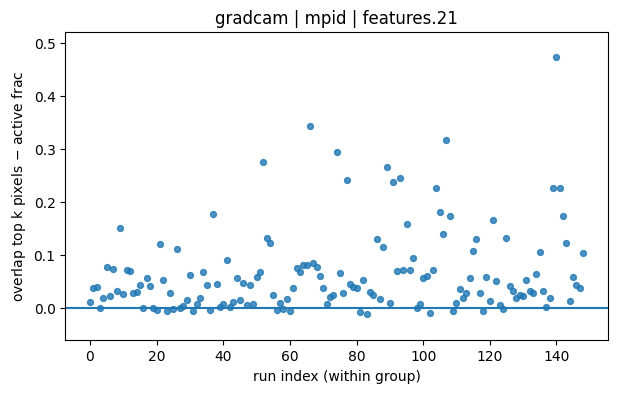

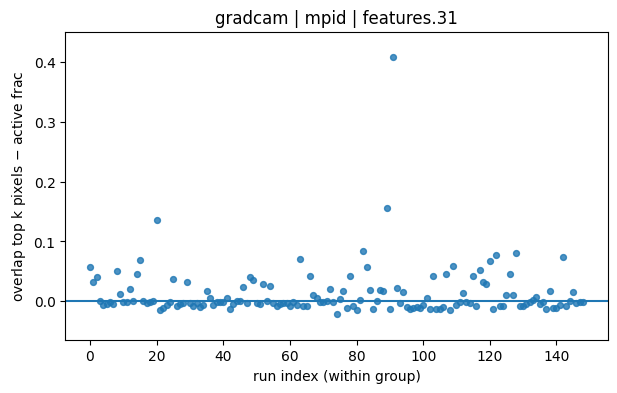

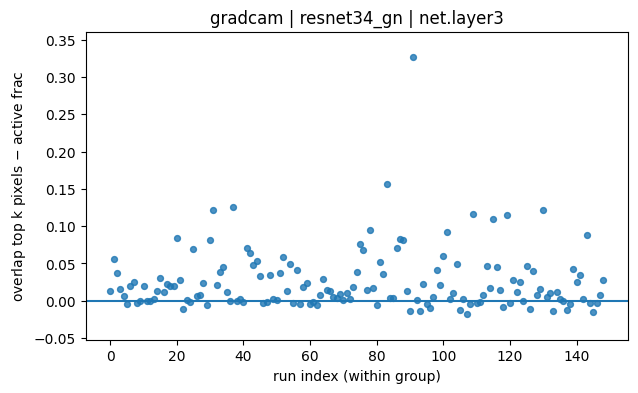

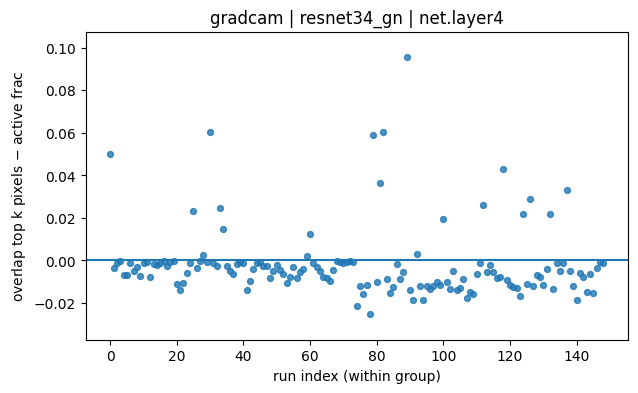

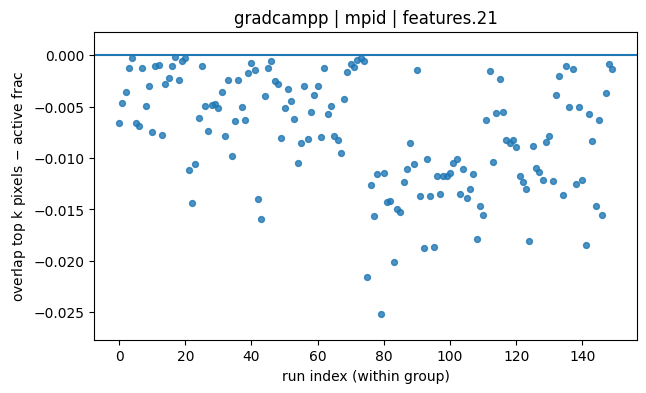

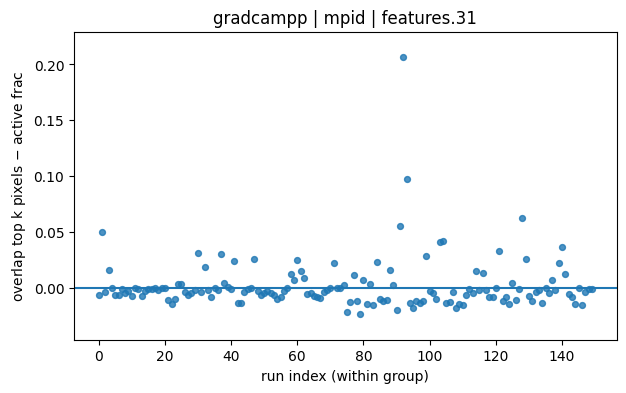

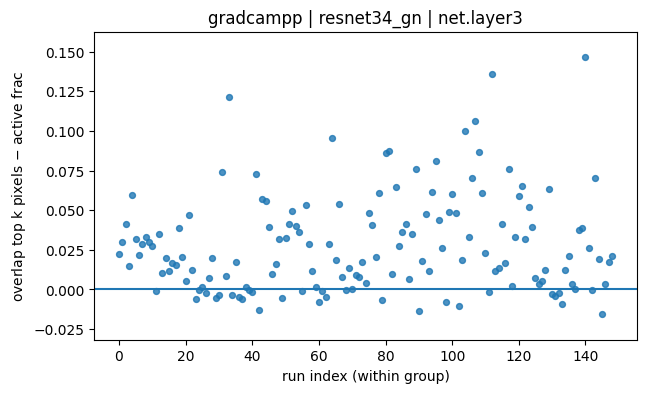

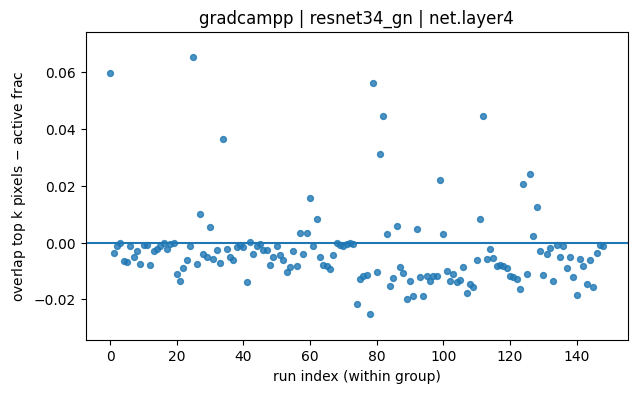

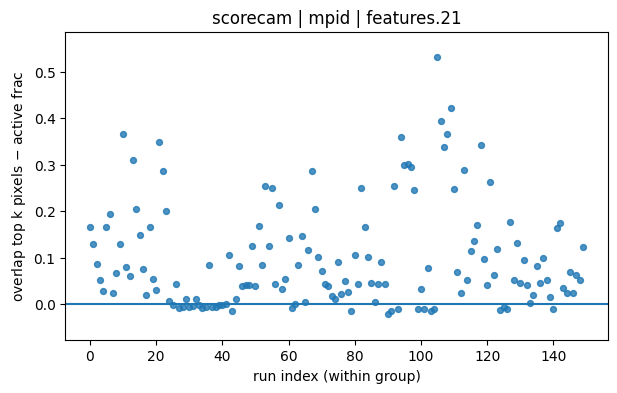

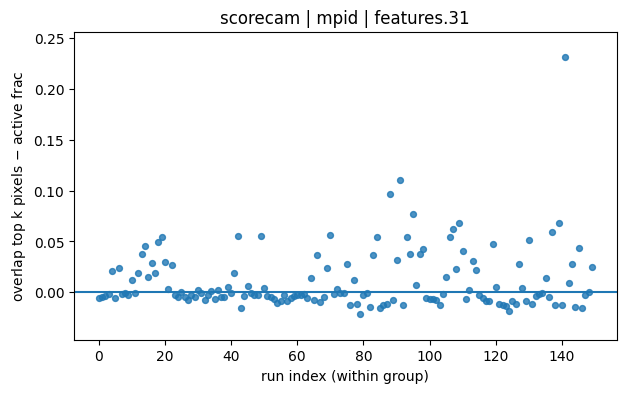

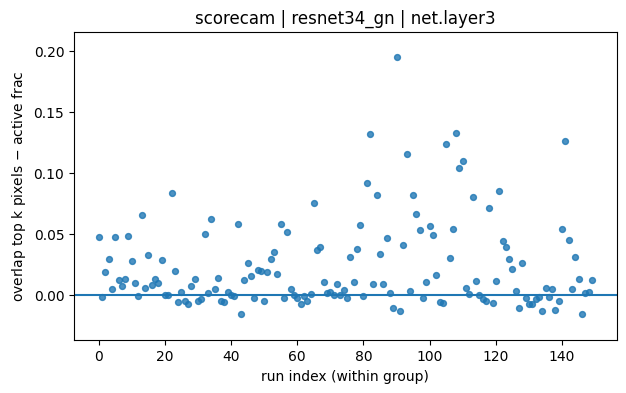

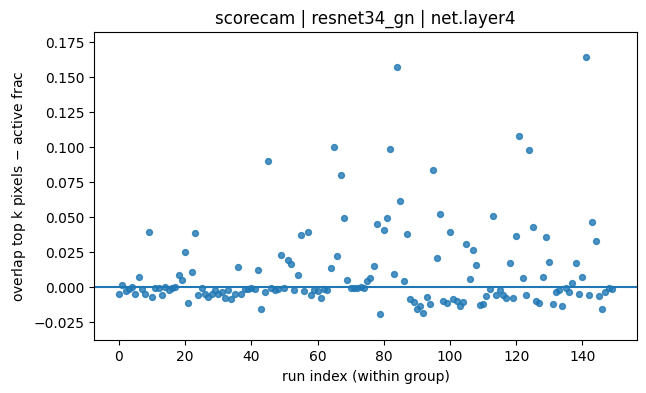

In [106]:
import numpy as np
import matplotlib.pyplot as plt

active_col = "diagnostics.active_frac"
ov_sig_col = "diagnostics.overlap_topk_signal"

needed = [active_col, ov_sig_col, "method_hint", "model", "layer_name"]
missing = [c for c in needed if c not in df.columns]

if missing:
    print("Missing columns:", missing)
    print("Columns that look relevant:")
    print([c for c in df.columns if "overlap" in c.lower() or "active_frac" in c.lower() or "layer" in c.lower()])
else:
    tmp = df.dropna(subset=[active_col, ov_sig_col, "method_hint", "model", "layer_name"]).copy()
    tmp = tmp[tmp["method_hint"] != "integrad"].copy()

    tmp["above_random"] = tmp[ov_sig_col] - tmp[active_col]
    # tmp["above_random"] = tmp[ov_sig_col]

    # y_min = float(tmp["above_random"].min())
    # y_max = float(tmp["above_random"].max())

    keep = (
    tmp.groupby(["method_hint", "model", "layer_name"])
    .size()
    .reset_index(name="N")
    )

    # Plot each group
    for _, row in keep.sort_values(["method_hint", "model", "layer_name"]).iterrows():
        m, model, layer, N = row["method_hint"], row["model"], row["layer_name"], int(row["N"])
        sub = tmp[(tmp["method_hint"] == m) & (tmp["model"] == model) & (tmp["layer_name"] == layer)].copy()

        # For consistent y-limits across all plots (easier comparison)
        y_min = float(sub["above_random"].min())
        y_max = float(sub["above_random"].max())
        y_frac = 0.1*(abs(y_min)+y_max)

        plt.figure(figsize=(7,4))
        plt.scatter(np.arange(len(sub)), sub["above_random"], alpha=0.8, s=18)
        plt.axhline(0.0)
        # plt.ylim(y_min, y_max)
        plt.ylim(y_min-y_frac, y_max+y_frac)
        plt.ylabel(r"overlap top k pixels $\minus$ active frac")
        # plt.ylabel(r"overlap top k pixels")
        plt.xlabel("run index (within group)")
        plt.title(f"{m} | {model} | {layer}")
        plt.show()


In [107]:
active = "diagnostics.active_frac"
ov = "diagnostics.overlap_topk_signal"

tmp = df.dropna(subset=[active, ov]).copy()
tmp = tmp[tmp["method_hint"] != "integrad"]

tmp["above_random"] = tmp[ov] - tmp[active]
tmp["enrichment"] = tmp[ov] / np.clip(tmp[active], 1e-9, None)

for m, g in tmp.groupby("method_hint"):
    print(m,
          "N=", len(g),
          "pct(above_random>0)=", (g["above_random"]>0).mean(),
          "median_above_random=", g["above_random"].median(),
          "median_enrichment=", g["enrichment"].median())


gradcam N= 596 pct(above_random>0)= 0.5419463087248322 median_above_random= 0.00286954889221075 median_enrichment= 1.523529793961768
gradcampp N= 598 pct(above_random>0)= 0.3076923076923077 median_above_random= -0.002780914306640625 median_enrichment= 0.0
scorecam N= 600 pct(above_random>0)= 0.59 median_above_random= 0.006913494035880194 median_enrichment= 2.2775311971671224


In [108]:
cols = ["method_hint","model","layer_name",active,ov]
tmp = df.dropna(subset=[active, ov]).copy()
tmp["above_random"] = tmp[ov] - tmp[active]
tmp["enrichment"] = tmp[ov] / np.clip(tmp[active], 1e-9, None)

grp = tmp.groupby(["method_hint","model","layer_name"])
out = grp.agg(
    N=("above_random","size"),
    pct_pos=("above_random", lambda s: (s>0).mean()),
    med_above=("above_random","median"),
    med_enrich=("enrichment","median"),
)
out = out.sort_values(["method_hint","med_enrich"], ascending=[True, False])
out.head(20)


N   pct_pos  med_above  med_enrich
method_hint model       layer_name                                       
gradcam     mpid        features.21  149  0.872483   0.039855    9.400572
            resnet34_gn net.layer3   149  0.758389   0.012656    2.812640
            mpid        features.31  149  0.402685  -0.000942    0.227385
            resnet34_gn net.layer4   149  0.134228  -0.005005    0.000000
gradcampp   resnet34_gn net.layer3   149  0.805369   0.020475    4.691619
            mpid        features.21  150  0.000000  -0.007425    0.000000
                        features.31  150  0.266667  -0.002892    0.000000
            resnet34_gn net.layer4   149  0.161074  -0.005013    0.000000
scorecam    mpid        features.21  150  0.826667   0.058076   14.877857
            resnet34_gn net.layer3   150  0.706667   0.010012    3.111903
            mpid        features.31  150  0.433333  -0.001168    0.438927
            resnet34_gn net.layer4   150  0.393333  -0.001114    0.211488

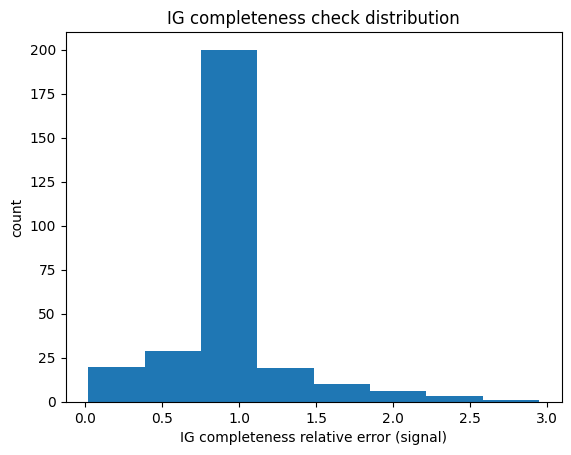

,entry,method_hint,diagnostics.ig_completeness.signal.rel_error
1475,2013,integrad,81.509613
1473,11494,integrad,19.519667
1435,2550,integrad,14.905017
1439,4128,integrad,13.195386
1433,1493,integrad,10.873414
1436,3117,integrad,9.038453
1474,1753,integrad,6.857551
1477,464,integrad,6.761392
1476,3481,integrad,6.027570
1437,3662,integrad,4.229319


In [109]:
ig_err_col = "diagnostics.ig_completeness.signal.rel_error"
if ig_err_col not in df.columns:
    print("No IG completeness column found. Columns that include 'ig_completeness':")
    print([c for c in df.columns if "ig_completeness" in c.lower()])
else:
    ig = df[df["method_hint"]=="integrad"]
    plt.figure()
    # Get the data and drop NaNs
    data = ig[ig_err_col].dropna()
    # Filter to keep only values <= 10
    filtered_data = data[data <= 3].values
    plt.hist(filtered_data, bins=8)
    plt.xlabel("IG completeness relative error (signal)")
    plt.ylabel("count")
    plt.title("IG completeness check distribution")
    plt.show()

    display(ig[["entry","method_hint",ig_err_col]].sort_values(ig_err_col, ascending=False).head(20))


In [116]:
import numpy as np
import matplotlib.pyplot as plt

def _pick_curve_prefix(row):
    """
    Returns the curve prefix that exists for this row:
      - scorecam:  diagnostics.curves
      - gradcam family: diagnostics.curves_signalmap
    """
    # Score-CAM style
    if isinstance(row.get("diagnostics.curves.fractions", None), list):
        return "diagnostics.curves"
    # GradCAM/GradCAM++ style (your JSON shows curves_signalmap)
    if isinstance(row.get("diagnostics.curves_signalmap.fractions", None), list):
        return "diagnostics.curves_signalmap"
    return None

def _get_list(row, key):
    v = row.get(key, None)
    return v if isinstance(v, list) else None

def _get_auc(row, key):
    v = row.get(key, None)
    return v if isinstance(v, (int, float, np.floating)) else None

def plot_curves_separated(entry: int,
                         show_background=True,
                         show_random=True,
                         figsize=(12, 5),
                         legend_right=0.72):
    """
    Makes separate plots for each unique (method, model, layer_name) for a given entry.
    Works with both:
      - Score-CAM JSON: diagnostics.curves.*
      - Grad-CAM JSON: diagnostics.curves_signalmap.*
    """

    # Choose entry column
    if "entry_id" in df.columns:
        entry_col = "entry_id"
    elif "entry" in df.columns:
        entry_col = "entry"
    elif "entry_number" in df.columns:
        entry_col = "entry_number"
    else:
        raise ValueError("No entry column found (expected entry_id / entry / entry_number).")

    # Choose method column
    meth_col = "method_hint"

    # Filter rows for entry
    sub = df[df[entry_col] == entry].copy()
    if sub.empty:
        print(f"No rows found for entry={entry}")
        return

    # Ensure these exist
    if "model" not in sub.columns:
        sub["model"] = sub.get("Model", "?")
    if "layer_name" not in sub.columns:
        # fall back to other possible layer fields
        sub["layer_name"] = sub.get("layer", sub.get("Layer", sub.get("layer_preset", "?")))

    # Group by (method, model, layer_name)
    groups = sub.groupby([meth_col, "model", "layer_name"], dropna=False)

    def plot_one_group(g, method, model, layer):
        # Use first row to decide prefix, but allow rows with different prefixes (just skip incompatible)
        # Most of the time a group has one prefix.
        fig, ax = plt.subplots(figsize=figsize)

        def add_curves_for_row(row, label_prefix=""):
            pref = _pick_curve_prefix(row)
            if pref is None:
                return

            fractions = _get_list(row, f"{pref}.fractions")
            if fractions is None:
                return
            x = np.array(fractions, dtype=float)

            panel_colors = {
                "deletion":  '#3366FF',      # medium blue
                "insertion": '#FF3333',      # medium red
            }
            
            # curves
            for panel in ("deletion", "insertion"):
                color = panel_colors[panel]
                # signal
                y_sig = _get_list(row, f"{pref}.{panel}.signal")
                y_bkg = _get_list(row, f"{pref}.{panel}.background")
                y_rsig = _get_list(row, f"{pref}.random_{panel}.signal")
                y_rbkg = _get_list(row, f"{pref}.random_{panel}.background")

                # AUCs: handle both conventions:
                # Score-CAM: pref + ".deletion_auc.signal"
                # Grad-CAM JSON: pref + ".auc.deletion_signal"
                auc_sig = (
                    _get_auc(row, f"{pref}.{panel}_auc.signal") or
                    _get_auc(row, f"{pref}.auc.{panel}_signal")
                )
                auc_bkg = (
                    _get_auc(row, f"{pref}.{panel}_auc.background") or
                    _get_auc(row, f"{pref}.auc.{panel}_background")
                )
                auc_rsig = (
                    _get_auc(row, f"{pref}.random_{panel}_auc.signal") or
                    _get_auc(row, f"{pref}.auc.random_{panel}_signal")
                )
                auc_rbkg = (
                    _get_auc(row, f"{pref}.random_{panel}_auc.background") or
                    _get_auc(row, f"{pref}.auc.random_{panel}_background")
                )

                # Plot with labels that encode panel+class
                # To keep one axis, we encode panel in label and use different lines.
                if y_sig is not None:
                    lab = f"{label_prefix}{panel} sig" + (f" (AUC={auc_sig:.3f})" if auc_sig is not None else "")
                    ax.plot(x, y_sig, label=lab, linestyle='-', color=color)
                if show_random and y_rsig is not None:
                    lab = f"{label_prefix}random {panel} sig" + (f" (AUC={auc_rsig:.3f})" if auc_rsig is not None else "")
                    ax.plot(x, y_rsig, label=lab, linestyle='--', color=color)

                if show_background and y_bkg is not None:
                    lab = f"{label_prefix}{panel} bkg" + (f" (AUC={auc_bkg:.3f})" if auc_bkg is not None else "")
                    ax.plot(x, y_bkg, label=lab, linestyle='-', color=color)
                if show_background and show_random and y_rbkg is not None:
                    lab = f"{label_prefix}random {panel} bkg" + (f" (AUC={auc_rbkg:.3f})" if auc_rbkg is not None else "")
                    ax.plot(x, y_rbkg, label=lab, linestyle='--', color=color)

        # If multiple runs exist in this group (e.g. different files), plot each row.
        # To avoid identical legend labels repeated, we prefix with run index if needed.
        for i, (_, row) in enumerate(g.iterrows()):
            # If you want only one row per group, replace with row = g.iloc[0]
            prefix = "" if len(g) == 1 else f"run{i+1}: "
            add_curves_for_row(row, label_prefix=prefix)

        ax.set_xlabel("fraction")
        ax.set_ylabel("score")
        # Put method/model/layer in title exactly as you requested
        ax.set_title(f"entry={entry} | method={method} | model={model} | layer={layer}")

        # Legend outside, reserve width
        fig.subplots_adjust(right=legend_right)
        ax.legend(loc="center left", bbox_to_anchor=(1.01, 0.5), fontsize=8, borderaxespad=0.0)
        plt.show()

    # Make one figure per group
    for (method, model, layer), g in groups:
        if method!="integrad":
            plot_one_group(g, method, model, layer)


In [117]:
# Worst IG completeness cases
ig_err_col = "diagnostics.ig_completeness.signal.rel_error"
if ig_err_col in df.columns:
    ig = df[df["method_hint"].str.contains("integr", na=False) | df["method_hint"].str.contains("ig", na=False)]
    display(ig[["entry","name",ig_err_col]].sort_values(ig_err_col, ascending=False).head(5))

# Worst overlap-minus-active cases (signal)
active_col = "diagnostics.active_frac"
ov_sig_col = "diagnostics.overlap_topk_signal"
if active_col in df.columns and ov_sig_col in df.columns:
    df["overlap_minus_active_signal"] = df[ov_sig_col] - df[active_col]
    display(df[["entry","method_hint","layer_name","name","overlap_minus_active_signal"]].sort_values("overlap_minus_active_signal").head(5))


,entry,name,diagnostics.ig_completeness.signal.rel_error
1475,2013,integrad__ENTRY_2013_meta.txt,81.509613
1473,11494,integrad__ENTRY_11494_meta.txt,19.519667
1435,2550,integrad__ENTRY_2550_meta.txt,14.905017
1439,4128,integrad__ENTRY_4128_meta.txt,13.195386
1433,1493,integrad__ENTRY_1493_meta.txt,10.873414


,entry,method_hint,layer_name,name,overlap_minus_active_signal
321,2166,gradcam,net.layer4,gradcam__ENTRY_2166_meta_net.layer4.txt,-0.025181
908,2166,gradcampp,features.21,gradcampp__ENTRY_2166_meta_features.21.txt,-0.025181
919,2166,gradcampp,net.layer4,gradcampp__ENTRY_2166_meta_net.layer4.txt,-0.025181
909,2166,gradcampp,features.31,gradcampp__ENTRY_2166_meta_features.31.txt,-0.023655
894,1427,gradcampp,features.21,gradcampp__ENTRY_1427__nu_overlay_meta_feature...,-0.021568


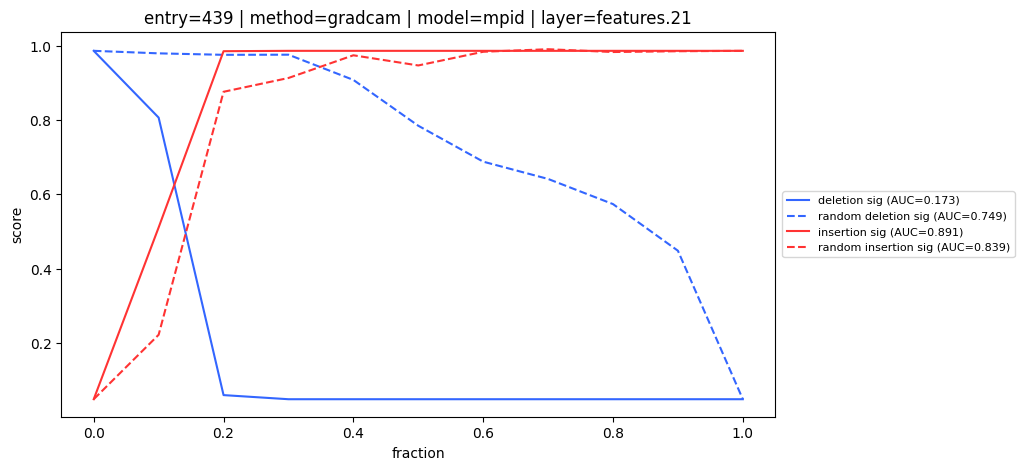

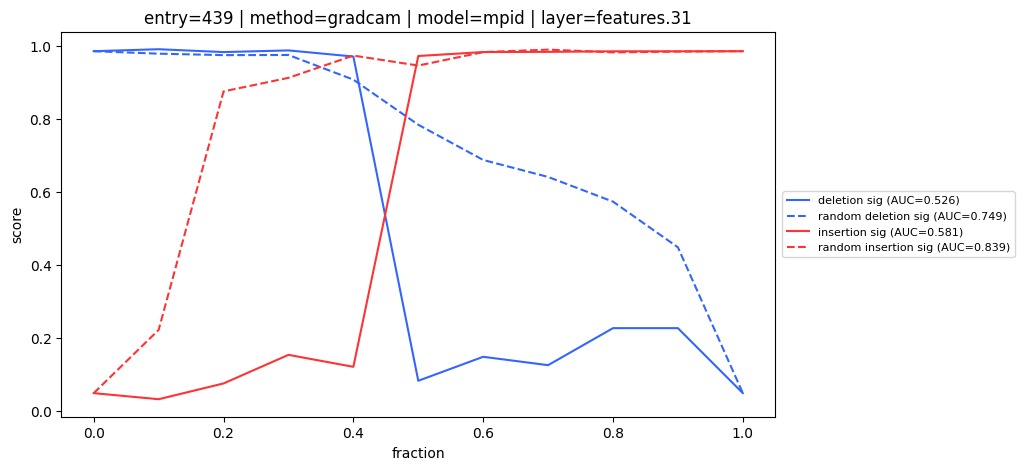

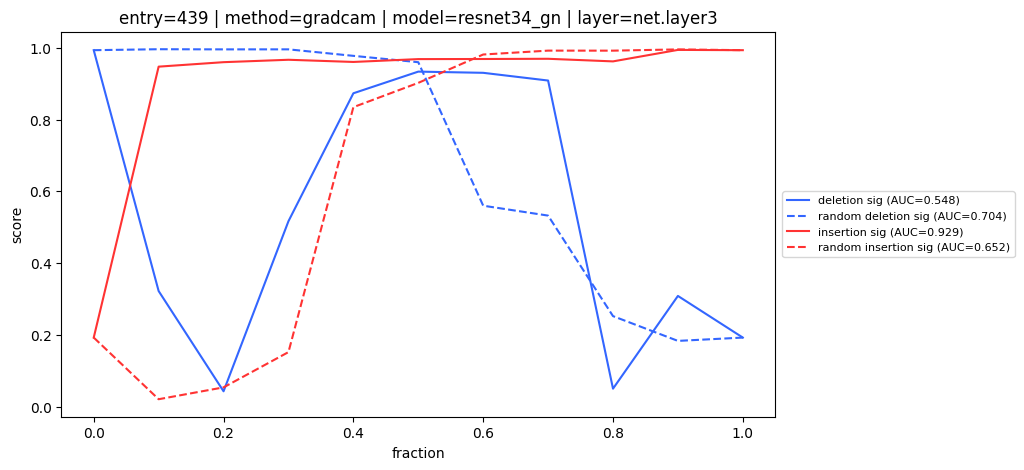

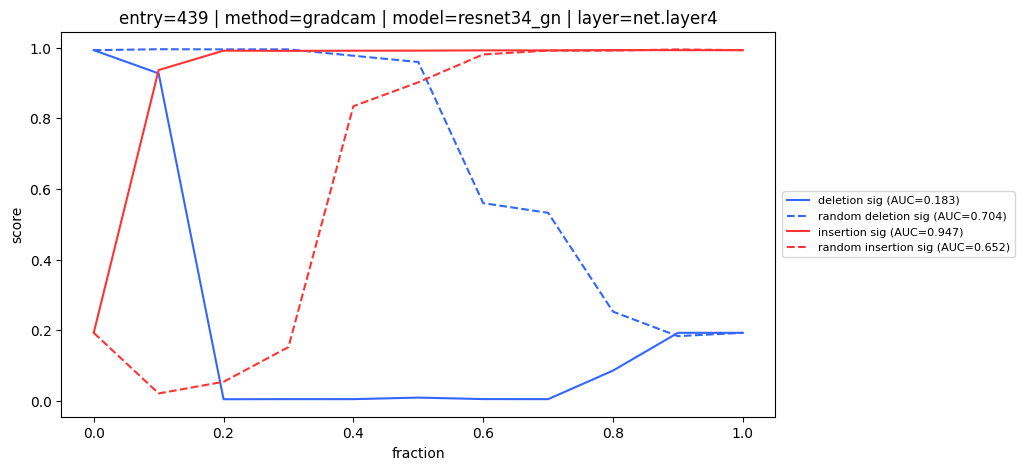

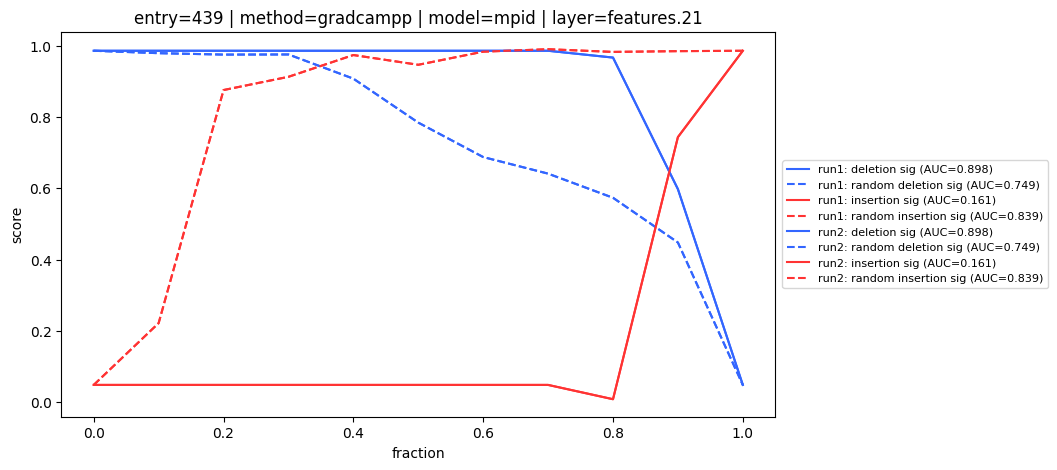

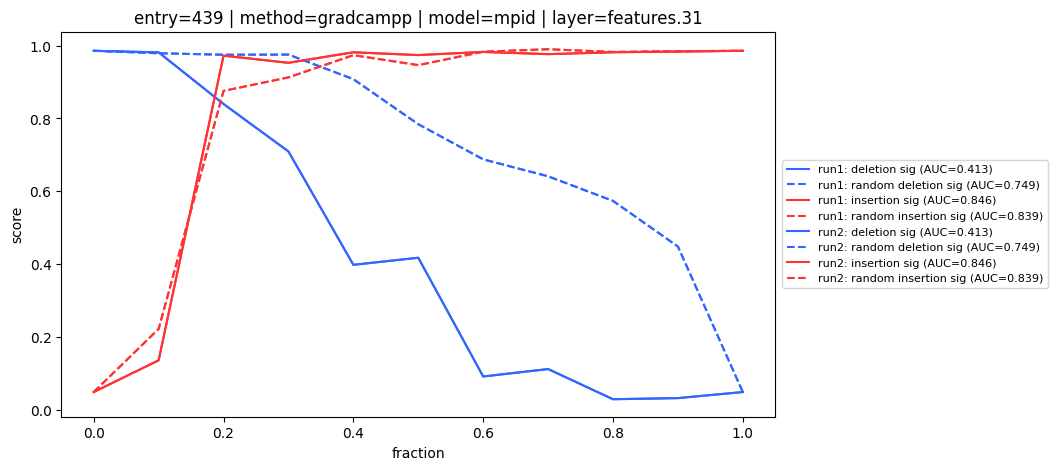

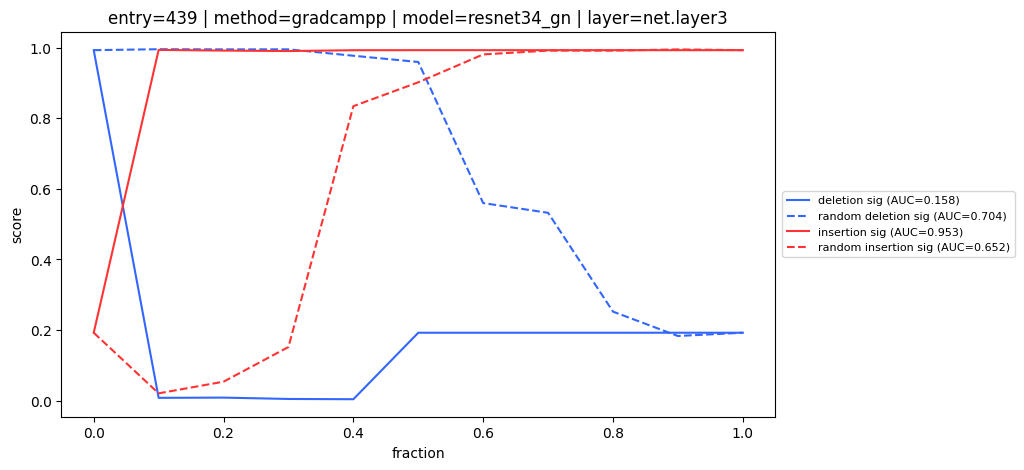

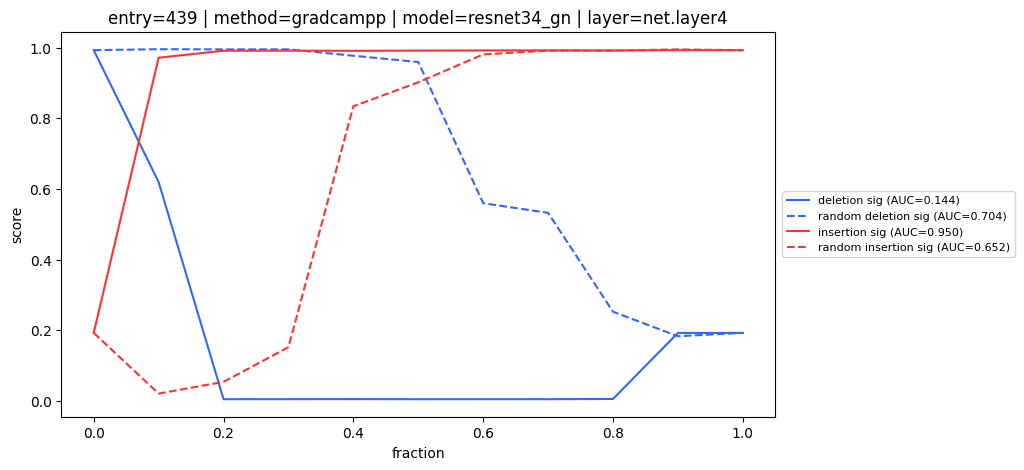

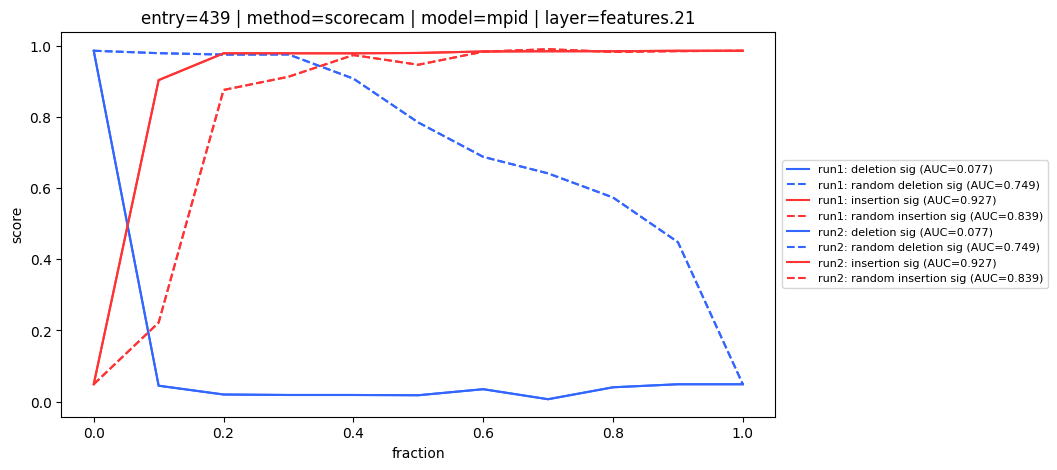

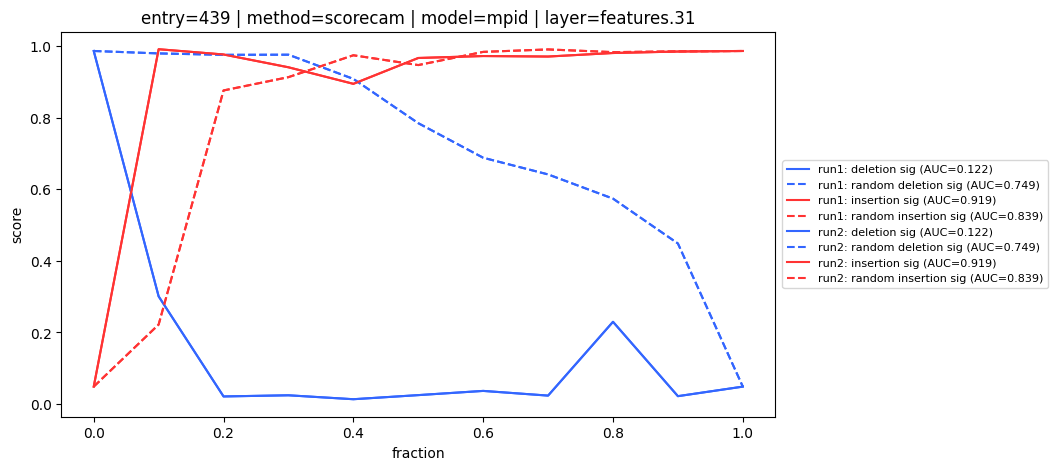

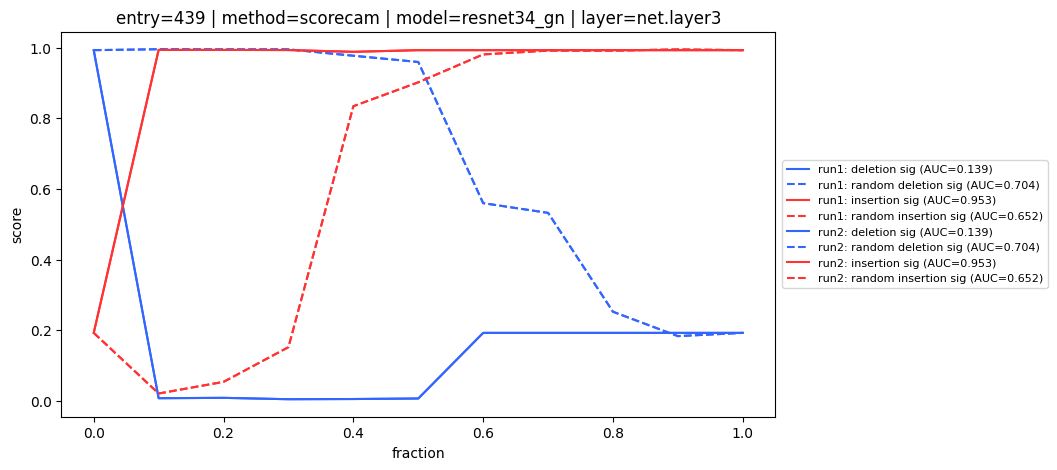

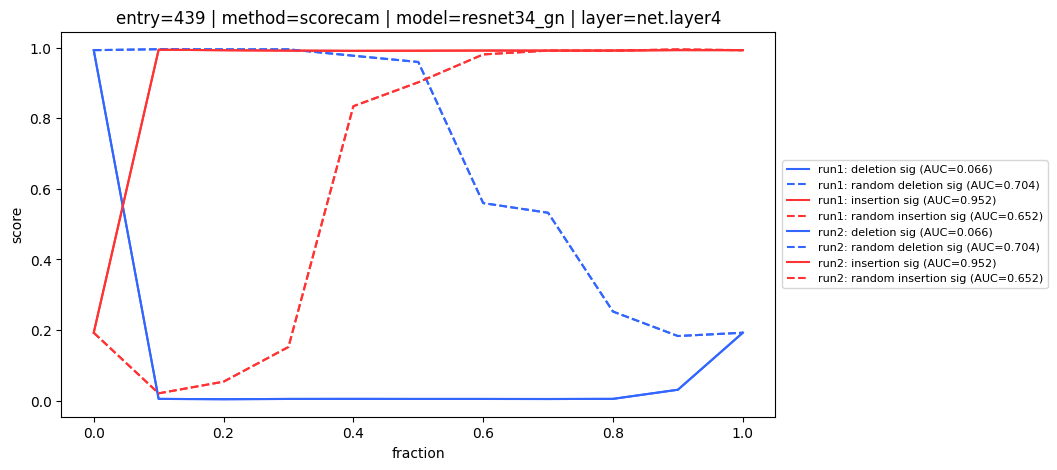

In [118]:
# Example:
plot_curves_separated(439, show_background=False, show_random=True)